## KPI Calculation

In the following section, we calculate diiferent KPIs that aim to measure the performance of the fleet in real time. Thus, they are calculated per hour. Specifically, we will take a look at the utilization of the fleet, the revenue generated and the coverage via the percentage of underutilized stations. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium

In [2]:
trips = pd.read_pickle('../00_data/trips.pkl')
trips_hourly = pd.read_pickle('../00_data/trips_hourly.pkl')
trips_hourly_engineered = pd.read_pickle('../00_data/trips_hourly_engineered.pkl')

In [3]:
trips_hourly_engineered.head(2)

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling,available_bikes,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,is_holiday
index,,,,,,,,,,,,,,
2019-01-01 01:00:00,8.0,2.0,872.0,870.0,15.6,15.6,0.0,1,1,1,1,1,True,True
2019-01-01 02:00:00,11.0,4.0,872.0,868.0,15.0,15.0,0.0,2,1,1,1,1,True,True


Looking at the first entries of the trip dataset, we can observe that there are some hours where no trips took place. In order to avoid a bias in further calculations where we average over entries, we fill in the missing values so that the dataframe contains data for every single hour. 

In [4]:
# create new datetime index based on specified range
index_complete = pd.date_range(start='2019-01-01 01:00:00', end='2019-12-31 23:00:00', freq="H")

# create rows with missing intervals and fill missing data
trips_hourly_engineered = trips_hourly_engineered.reindex(index_complete, fill_value=np.nan).fillna(0)
trips_hourly_engineered.head(2)

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling,available_bikes,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,is_holiday
2019-01-01 01:00:00,8.0,2.0,872.0,870.0,15.6,15.6,0.0,1.0,1.0,1.0,1.0,1.0,True,True
2019-01-01 02:00:00,11.0,4.0,872.0,868.0,15.0,15.0,0.0,2.0,1.0,1.0,1.0,1.0,True,True


We can see that the missing time slots, for example on hour 4 and 5 on the first day have been filled with 0s. Therefore, we can now start the calculations.

### Fleet Utilization

For utilization, we caculate both the absolute and the relative utilization. For the relative values, we divide by the number of bicycles that are currently in use as previously calculated.

In [5]:
trips_hourly_engineered["starting_trips"].mean

<bound method NDFrame._add_numeric_operations.<locals>.mean of 2019-01-01 01:00:00     8.0
2019-01-01 02:00:00    11.0
2019-01-01 03:00:00     2.0
2019-01-01 04:00:00     0.0
2019-01-01 05:00:00     0.0
                       ... 
2019-12-31 19:00:00    28.0
2019-12-31 20:00:00    40.0
2019-12-31 21:00:00    23.0
2019-12-31 22:00:00    16.0
2019-12-31 23:00:00    12.0
Freq: H, Name: starting_trips, Length: 8759, dtype: float64>

In [6]:
#caculate hourly utilization 
trips_hourly_engineered["utilization_absolute"]  =  trips_hourly_engineered["ongoing_trips_prev"]+ trips_hourly_engineered["starting_trips"]
trips_hourly_engineered["utilization_percentage"] = trips_hourly_engineered["utilization_absolute"] / trips_hourly_engineered["in_service_bikes_rolling"]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


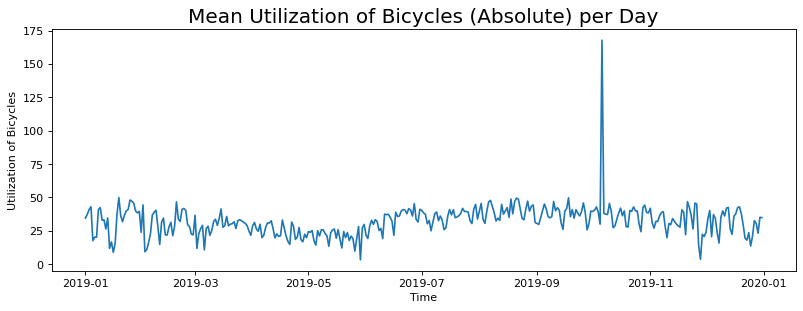

In [7]:
#plot absolute utilization per day
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(trips_hourly_engineered["utilization_absolute"].resample("d").mean())
ax.set_title("Mean Utilization of Bicycles (Absolute) per Day", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Utilization of Bicycles")
plt.show()
#ax.figure.savefig("Util_Abs.png")

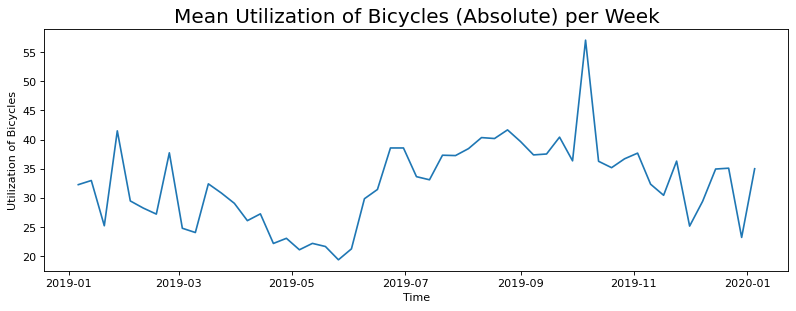

In [8]:
#plot absolute utilization per week 
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(trips_hourly_engineered["utilization_absolute"].resample("w").mean())
ax.set_title("Mean Utilization of Bicycles (Absolute) per Week", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Utilization of Bicycles")
plt.show()
#ax.figure.savefig("Util_Abs.png")

As visible, the absolute utilization is higher during the second part of the year and peaks in Oktober. There is one short time period in particular where demand seems to peak with the rest of the month being more comparable to the other summer month. Lowest Utilization is reached around May and the beginning of June. The graph is rather consistent with few unexpected jumps. Surprisingly seasons do not seem to play a big role.

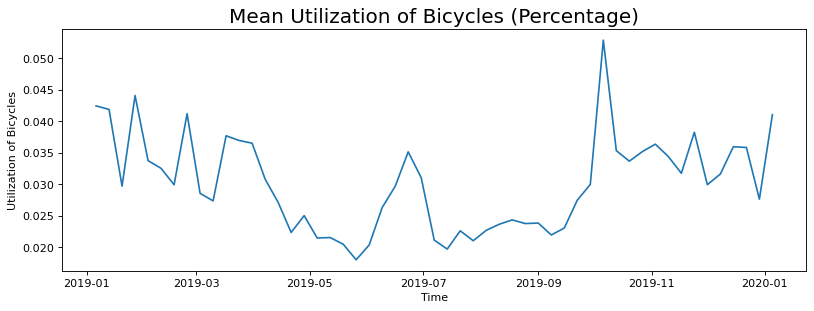

In [9]:
#plot relative utilization
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(trips_hourly_engineered["utilization_percentage"].resample("w").mean())
ax.set_title("Mean Utilization of Bicycles (Percentage)", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Utilization of Bicycles")
plt.show()
ax.figure.savefig("Util_Perc.png")

This graph, in comparison, is more erratic. However, for the percentage calculation, we have to keep in mind that the size of the bike fleet was calculated by us based on how long a bicycle has or has not been used and therefore there is a potential for error. We can see that the utilization seem to go up and down again frequently however the overall trend is more consistent. We can oberseve only a small drop in the summer months. We know that the fleet size increases significantly in these months which explains why the relative utilization drops while the absolute utiliation is higher. The outlier in October is still present in the relative numbers. 

### Revenue

For the revenue, we calcuate an upper and lower bound because we lack information on how often pass holder reuse their subscription. Thus it is diffcult to estimate which trips from pass holder represent a new subscription and which subscriptions are already paid for.

#### Lower Bound

The lower bound was calculated by only including the walk-up trips without a subscription attached. We then applied the pricing model of 1.75 dollars per 30 minutes trip duration.

In [10]:
#read data and filter for walkup trips
trips = pd.read_pickle('../00_data/trips.pkl')
trips_walkup = trips[trips["user_type"]=="Walk-up"]
trips_walkup['start_time_floored'] = trips_walkup['start_time'].dt.floor('1H')

/tmp/ipykernel_225676/3400362604.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_walkup['start_time_floored'] = trips_walkup['start_time'].dt.floor('1H')


In [11]:
#round up the duration to the next 30 min interval and calculate the revenue as 1.75 dollars per 30 min
trips_walkup["rev"] = trips_walkup["duration"].dt.ceil("30T")
trips_walkup["rev"] = trips_walkup["rev"].dt.total_seconds().astype(int)/60/30*1.75

/tmp/ipykernel_225676/517014658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_walkup["rev"] = trips_walkup["duration"].dt.ceil("30T")
/tmp/ipykernel_225676/517014658.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_walkup["rev"] = trips_walkup["rev"].dt.total_seconds().astype(int)/60/30*1.75


In [12]:
trips_walkup.head(2)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_latitude,...,education_poi_start,arts_and_culture_poi_start,sports_poi_start,sustenance_poi_end,public_transport_poi_end,education_poi_end,arts_and_culture_poi_end,sports_poi_end,start_time_floored,rev
0,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,3075,05992,Walk-up,Main & 1st,Broadway & 9th,0 days 00:32:00,34.05194,...,2,4,0,67,51,0,4,4,2019-01-01,3.50
1,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,3075,05860,Walk-up,Main & 1st,Broadway & 9th,0 days 00:30:00,34.05194,...,2,4,0,67,51,0,4,4,2019-01-01,1.75


We can see that there is now a revenue column that show the amount the customer paid for the trip in US dollars. The first trip, for instance, lasted 32 minutes so the user paid 2 * 1.75 = 3.50 dollars. Now we can aggregate the data to hourly values and plot.

In [13]:
#Calculate hourly values
revenue_hourly= trips_walkup.groupby('start_time_floored').agg(
             rev = ('rev', 'sum'))


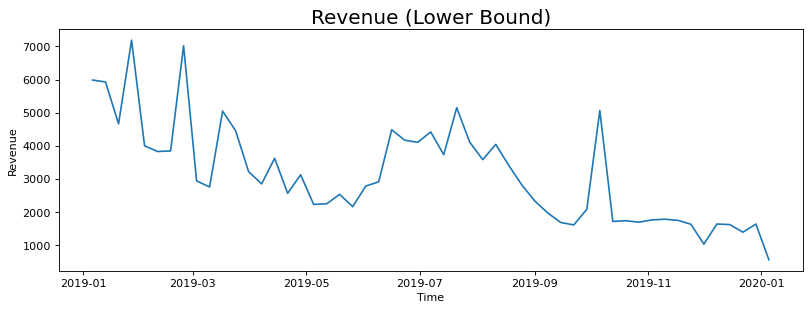

In [14]:
#Plot revenue
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(revenue_hourly["rev"].resample("w").sum())
ax.set_title("Revenue (Lower Bound)", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Revenue")
plt.show()
#ax.figure.savefig("Revenue_Lower.png")

While there are some fluctuations especially in the early part of the year, we can see a general down trend with a spike in the summer month. There is also a noteably high lower vbound for the revenue in october. This is quite surprising as it does not match up with the utilization plot discussed previously. It could imply that during those phases where it does not match, people made fewer but longer trips. 

#### Upper Bound

For the upper bound, we made the assumption that every trip made with a subscription represented a new pass sold. We differentiate between the different [types](https://bikeshare.metro.net/signup/#/) of passes. Walk-up user pay 1.75 dollars per 30 minutes as before. Pass holders pay the fee according to pass type plus 1.75 dollars for every additional 30 minutes after the first free half hour. 

In [15]:
#calculate the 30 minute intervals 
trips_all = trips
trips_all['start_time_floored'] = trips_all['start_time'].dt.floor('1H')

trips_all["rev"] = trips_all["duration"].dt.ceil("30T")
trips_all["rev"] = trips_all["rev"].dt.total_seconds().astype(int)/60/30
trips_all

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_latitude,...,education_poi_start,arts_and_culture_poi_start,sports_poi_start,sustenance_poi_end,public_transport_poi_end,education_poi_end,arts_and_culture_poi_end,sports_poi_end,start_time_floored,rev
0,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,3075,05992,Walk-up,Main & 1st,Broadway & 9th,0 days 00:32:00,34.05194,...,2,4,0,67,51,0,4,4,2019-01-01 00:00:00,2.0
1,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,3075,05860,Walk-up,Main & 1st,Broadway & 9th,0 days 00:30:00,34.05194,...,2,4,0,67,51,0,4,4,2019-01-01 00:00:00,1.0
2,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,3075,06006,Walk-up,Main & 1st,Broadway & 9th,0 days 00:28:00,34.05194,...,2,4,0,67,51,0,4,4,2019-01-01 00:00:00,1.0
3,2019-01-01 00:23:00,2019-01-01 00:51:00,3030,3075,06304,Walk-up,Main & 1st,Broadway & 9th,0 days 00:28:00,34.05194,...,2,4,0,67,51,0,4,4,2019-01-01 00:00:00,1.0
4,2019-01-01 00:24:00,2019-01-01 00:51:00,3030,3075,05846,Walk-up,Main & 1st,Broadway & 9th,0 days 00:27:00,34.05194,...,2,4,0,67,51,0,4,4,2019-01-01 00:00:00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222653,2019-12-12 15:54:39,2019-12-12 16:27:11,4455,4451,5982,Walk-up,Rowena & Hyperion,Melbourne & Vermont,0 days 00:32:32,34.10936,...,1,0,0,59,23,0,2,0,2019-12-12 15:00:00,2.0
222654,2019-12-12 15:55:19,2019-12-12 16:27:09,4455,4451,6552,Walk-up,Rowena & Hyperion,Melbourne & Vermont,0 days 00:31:50,34.10936,...,1,0,0,59,23,0,2,0,2019-12-12 15:00:00,2.0
222655,2019-12-31 16:43:31,2019-12-31 16:52:57,4455,4451,16342,Walk-up,Rowena & Hyperion,Melbourne & Vermont,0 days 00:09:26,34.10936,...,1,0,0,59,23,0,2,0,2019-12-31 16:00:00,1.0
222656,2019-12-20 12:26:06,2019-12-20 12:35:17,4472,4451,12377,Walk-up,Santa Monica & Sunset,Melbourne & Vermont,0 days 00:09:11,34.09260,...,3,0,2,59,23,0,2,0,2019-12-20 12:00:00,1.0


In [16]:
#Look up all user types
print(trips_all['user_type'].unique())

['Walk-up' 'Monthly Pass' 'Annual Pass' 'One Day Pass' 'Flex Pass'
 'Testing']


Besides the user types listed on Metro Bike Share's website and the testing trips identifed in the data cleaning section we also have trips that list "Flex Pass" as their user type. Because we do not have any information on this, we drop these trips in the revenue calculation.

In [17]:
#Drop all test rides and flex rides (no pricing info) and the first free 30 minutes for non walkup customers
trips_all = trips_all[trips_all["user_type"]!='Testing']
trips_all = trips_all[trips_all["user_type"]!='Flex Pass']
trips_all.loc[trips_all['user_type'] != 'Walk-up', 'rev'] = trips_all["rev"]-1

In [18]:
#Set revenue depending on user type
trips_all.loc[trips_all['user_type'] == 'Walk-up', 'rev'] = trips_all["rev"]*1.75
trips_all.loc[trips_all['user_type'] == 'Monthly Pass', 'rev'] = 17 + trips_all["rev"]*1.75
trips_all.loc[trips_all['user_type'] == 'Annual Pass', 'rev'] = 150 + trips_all["rev"]*1.75
trips_all.loc[trips_all['user_type'] == 'One Day Pass', 'rev'] = 5 + trips_all["rev"]*1.75

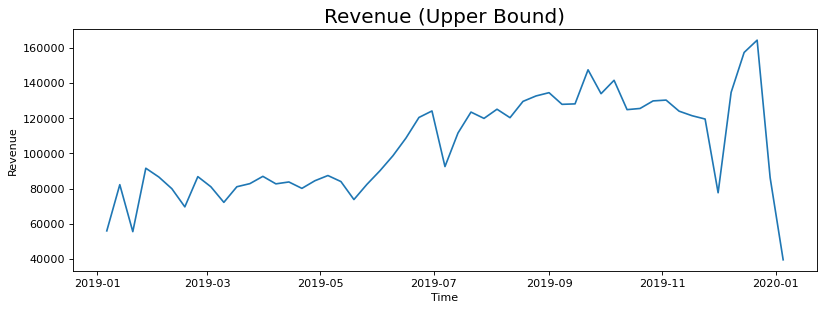

In [19]:
#Aggregate to hourly values and plot
upper_revenue_hourly= trips_all.groupby('start_time_floored').agg(
             rev = ('rev', 'sum'))

fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(upper_revenue_hourly["rev"].resample("w").sum())
ax.set_title("Revenue (Upper Bound)", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Revenue")
plt.show()
#ax.figure.savefig("Revenue_Upper.png")

Contrary to the lower bound, the upper bound has an overall upwards trend that is also high in the summer month but as well during fall. Moreover, there is high upper bound for revenue at the end of the year. This implies that the trips in the first half of the year were more often undertaken by walk-up users and those in the lter months of the year are more attributed to pass owners. 

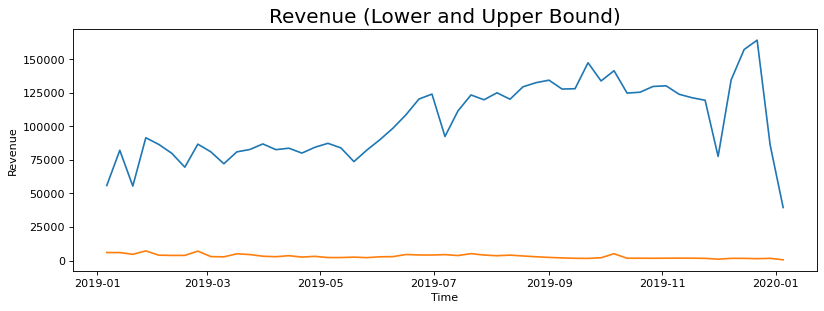

In [20]:
#plot upper and lower bound
fig,ax = plt.subplots(figsize=(12,4), dpi= 80) 

ax.plot(upper_revenue_hourly["rev"].resample("w").sum())
ax.plot(revenue_hourly["rev"].resample("w").sum())
ax.set_title("Revenue (Lower and Upper Bound)", fontsize=18, fontname="Arial")
ax.set_xlabel("Time")
ax.set_ylabel("Revenue")
plt.show()
#ax.figure.savefig("Revenue_Both.png")

As visible in the figure, the interval generated is quite large. While this is not ideal to make any definite statements, it provides definite bounds that do not have to rely on guesses about how often a pass holder makes use of their subscription. Moreover, it is likely that the true revenue lies closer to the lower bound, as a pass holder, especially of the more expensive monthly and yearly passes, is unlikely to rent a bicycle only once. If we were to expand this research, it would be helpful to collect additional data on which user undertook which trip to receive a more precise number.

### Station utilization
The KPI station utilization should show how many stations have low utilization.  
This information can therefore be used to identify stations that are not profitable.  

We will calculate hourly whether a station was used or not.
To interpret these values, we will then look at a time interval, e.g. 1 day and
calculate the average utilization per station. We will then set a threshold for
the average utilization and count all stations whose average utilization is below
the threshold.  

We will also give the possibility to visualize the underutilized stations on a map.

In [21]:
trips_df = pd.read_pickle('../00_data/trips.pkl')
stations_df = pd.read_pickle('../00_data/stations.pkl')
stations_df = stations_df.set_index("station_id")

First we will create a dataframe where one column represents the number of
trips per hour per station. It is easy to determine from that dataframe whether
a station is used or not.

In [22]:
station_ids = np.unique(
    np.concatenate([trips_df["start_station_id"], trips_df["end_station_id"]])
)

In [23]:
dates = pd.date_range(start='2019-01-01', end='2019-12-31', freq='h')

In [24]:
full_index = pd.MultiIndex.from_product([station_ids, dates], names=['station_id', 'date'])

In [25]:
trips_df["start_time_floored"] = trips_df["start_time"].dt.floor("h")
trips_per_station_hour = trips_df.groupby(
    ["start_station_id", "start_time_floored"]
).size()
trips_per_station_hour = (
    trips_per_station_hour.reindex(full_index).fillna(0).to_frame("n_trips")
)


Next we will define a method (`get_station_utilization`) to calculate the station utilization for each station
in a defined time interval. We will return the results as a dataframe.

In [26]:
def get_station_utilization(time_interval):
    station_utilization = trips_per_station_hour.loc[(slice(None), time_interval), :]
    station_utilization = (
        station_utilization[station_utilization["n_trips"] != 0]
        .groupby(level=[0])
        .count()
    )
    station_utilization = station_utilization.reindex(station_ids).fillna(0)
    station_utilization = station_utilization.rename(columns={'n_trips': 'days_used'})
    station_utilization['station_usage'] = station_utilization['days_used'] / len(time_interval)
    return station_utilization

We also define methods to get and print the number of underutilized stations
for a specific threshold and the number of unused stations. 

In [27]:
def get_n_underutilized_stations(station_utilization, threshold):
    station_utilization_kpi = len(station_utilization[
        station_utilization["station_usage"] < threshold
    ])
    return station_utilization_kpi

def get_n_unused_stations(station_utilization, threshold):
    return len(station_utilization[station_utilization["station_usage"] == 0])


In [28]:
def print_utilization_summary(station_utilization, threshold):
    n_underutilized_stations = get_n_underutilized_stations(
        station_utilization, threshold
    )
    n_unused_stations = get_n_unused_stations(station_utilization, threshold)
    print(
        f"{n_underutilized_stations} ({n_underutilized_stations/len(station_utilization) * 100:.2f}%) stations are underutilized"
    )
    print(
        f"{get_n_unused_stations(station_utilization, threshold)} ({n_unused_stations/len(station_utilization) * 100:.2f}%) stations are unused"
    )


Now let's look at the number of underutilized stations and unused stations for an
arbitrary day (04.12.2019).

In [29]:
station_utilization = get_station_utilization(
    pd.date_range(start="2019-12-04 00:00", end="2019-12-04 23:59", freq="h")
)
print_utilization_summary(station_utilization, threshold=0.2)

106 (81.54%) stations are underutilized
40 (30.77%) stations are unused


As we can see the number of underutilzed and unused stations is very high. We 
have to keep in mind that the specified time interval (1 day) also includes night
time. However, still the number of unused stations is high. 

Next we will calculate the number of underutilized stations and unused stations
for each day of the year. Then we can plot these numbers to see the trend.

In [30]:


utilization_over_year = pd.date_range(
    start="2019-01-01", end="2019-12-31", freq="d"
)
# print all methods of the object 
(utilization_over_year[0].floor("h"))

Timestamp('2019-01-01 00:00:00')

In [31]:
utilization_over_year = pd.date_range(
    start="2019-01-01", end="2019-12-31", freq="d"
).to_frame(name="date")

# Note: We use a for loop here, which is very efficient. However, the execution
# time is still very short.
station_utilization
for index, row in utilization_over_year.iterrows():
	start = row['date'].floor("h")
	end = (row['date'] + pd.Timedelta(hours=23)).floor("h")


	station_utilization = pd.date_range(start, end, freq="h")
	station_utilization = get_station_utilization(
        pd.date_range(start, end, freq="h")
    )

	utilization_over_year.loc[index, "unused_stations"] = get_n_unused_stations(
		station_utilization, threshold=0.2
	)
	utilization_over_year.loc[index, "underutilized_stations"] = get_n_underutilized_stations(
		station_utilization, threshold=0.2
	)
utilization_over_year = utilization_over_year.set_index("date")

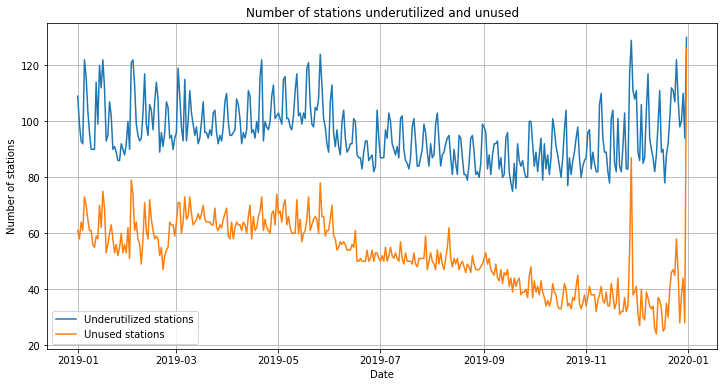

In [32]:
# plot utilization over year
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(utilization_over_year.index, utilization_over_year["underutilized_stations"])
ax.plot(utilization_over_year.index, utilization_over_year["unused_stations"])
ax.legend(["Underutilized stations", "Unused stations"])
ax.set_xlabel("Date")
ax.set_ylabel("Number of stations")
ax.set_title("Number of stations underutilized and unused")
ax.grid()
plt.show()
fig.savefig('../figures/station_utilization.pdf')


### Drawing underutilized stations on a map
Next we will draw the underutilized stations on a map. We will do this for a 
specific time interval. 

In [33]:
def draw_underutilized_stations(station_utilization, threshold):
    underutilized_stations = station_utilization[
        station_utilization["station_usage"] < threshold
    ]
    stations = stations_df.loc[underutilized_stations.index]
    stations = stations.merge(underutilized_stations, left_index=True, right_index=True)
    la_map = folium.Map(
        location=(
            34.052235,
            -118.243683,
        ),  # the orig mean values as location coordinates
        zoom_start=11,
        control_scale=True,
        max_zoom=20,
    )

    for index, row in stations.iterrows():
        days_used = int(row['days_used'])
        popup = folium.Popup(
            html=f"Station ID: <b>{index}</b><br>Days used: <b>{days_used}</b>",
			max_width=100,
			min_width=100,
        )
        color = 'red' if days_used == 0 else 'orange'
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=popup,
            icon=folium.Icon(color=color),
        ).add_to(la_map)

    return la_map


In [34]:
draw_underutilized_stations(station_utilization, threshold=0.2)